<a href="https://colab.research.google.com/github/YashiiJ/Credit-Risk-Modelling/blob/main/credit_risk_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary modules

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import cv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the data
df = pd.read_csv('/content/drive/MyDrive/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# shape of the data
df.shape

(32581, 12)

# Data Preprocessing

In [6]:
# checking for missing/null values
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# checking unique values of each object column
for col in df.select_dtypes(include = ['object']):
    print(col,':', df[col].unique())

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


We have null values in 2 columns only and not a significant percent is missing, hence we will drop it. Loan intrest rate is a important feature but there is insufficient information regarding imputating these values so its better to drop it as it wil not cause any significant changes.

In [9]:
# dropping null values from the dataset
df.dropna(inplace = True)

In [10]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [11]:
df.shape

(28638, 12)

# Exploratory Data Analysis

<Axes: >

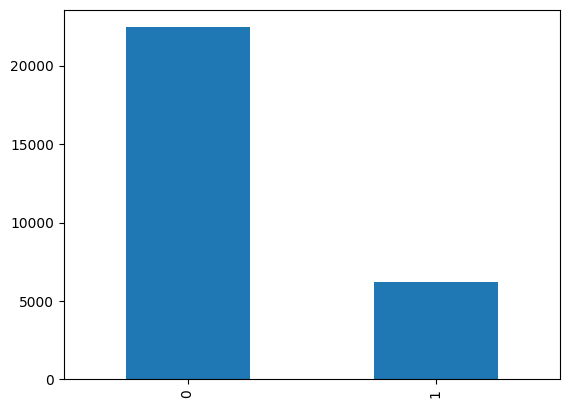

In [12]:
df['loan_status'].value_counts().plot(kind = 'bar')

In [13]:
df['loan_status'].value_counts()

0    22435
1     6203
Name: loan_status, dtype: int64

We can see class imbalance in the dataset. Less than 20% of data accounts for having defaulted on their files. We will handle this imbalace during training of the model.

In [18]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

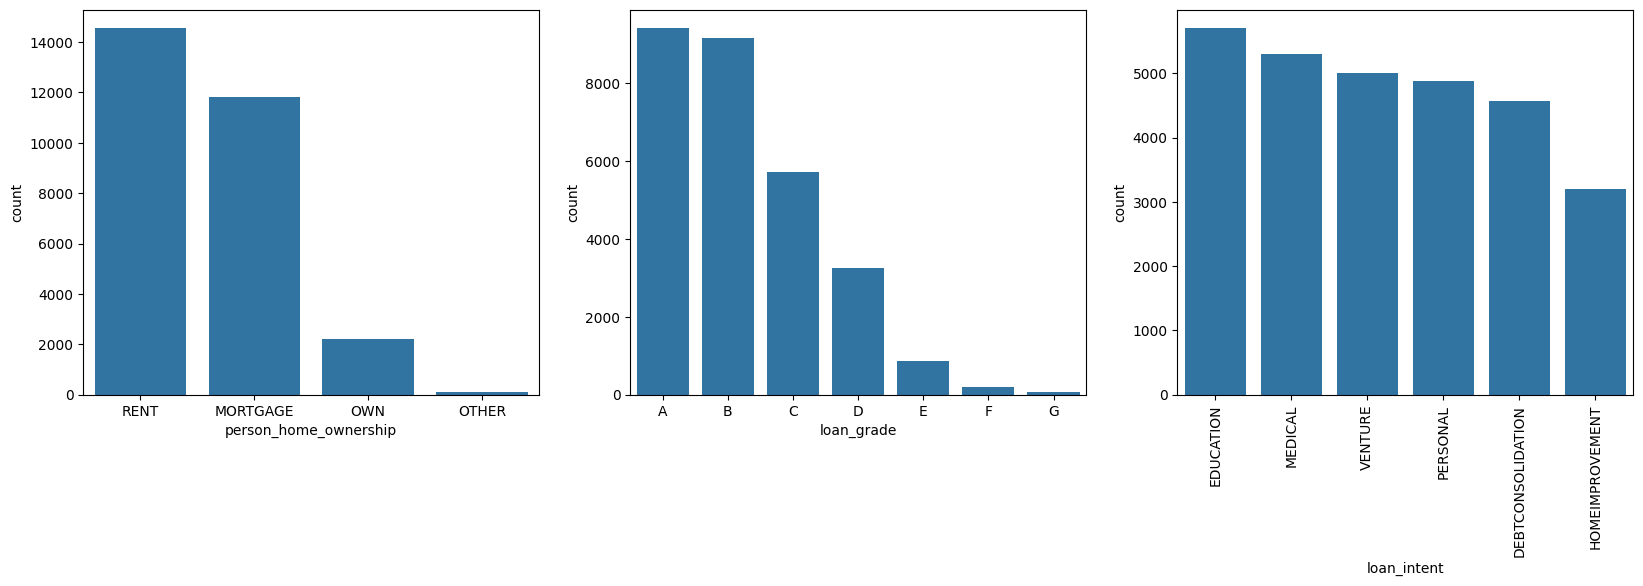

In [19]:
col = {0:'person_home_ownership', 1: 'loan_grade', 2: 'loan_intent'}
fig, ax = plt.subplots(1,3, figsize = (20,5))

for key, val in col.items():
    sns.countplot(data = df, x = val, ax = ax[key], order = df[val].value_counts().index)
    plt.xticks(rotation = 90)

The above graph shows a glance into categorical variables of the data. Majority of loan applicants rents a house. Loan grade falls into categories A and B, G being the least common grade. Loan intent plot shows a substantial number of applications for education and medical purposes.

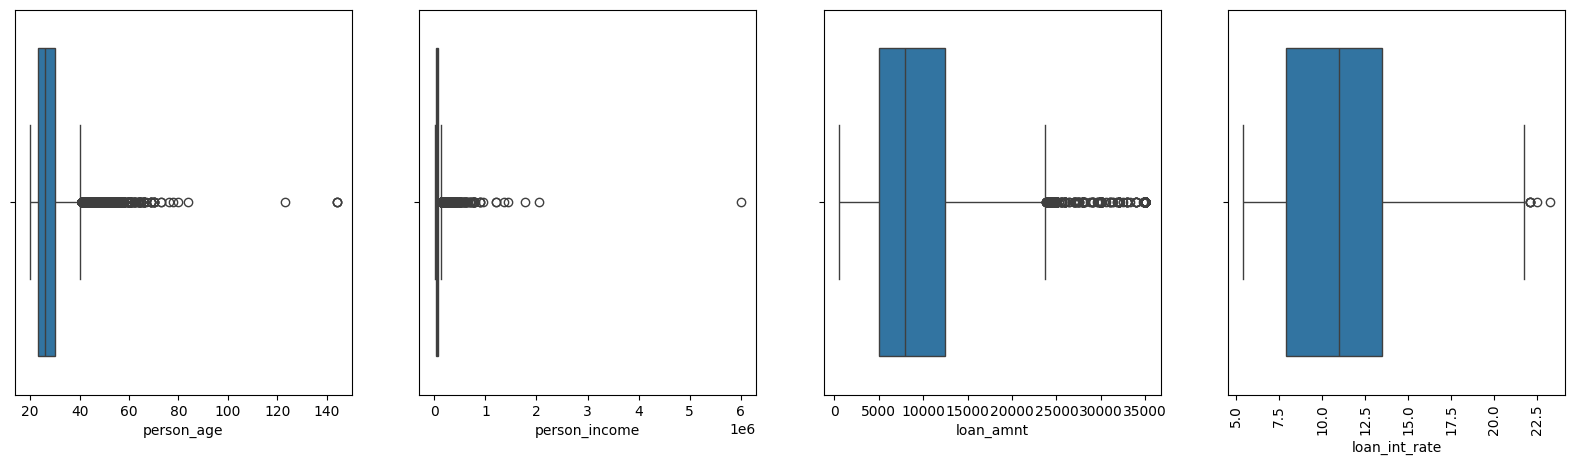

In [20]:
col = {0:'person_age', 1: 'person_income', 2: 'loan_amnt', 3: 'loan_int_rate'}
fig, ax = plt.subplots(1, len(col), figsize = (20,5))

for key, val in col.items():
    sns.boxplot(x = df[val], ax = ax[key])
    plt.xticks(rotation = 90)

There are some outliers in the data, eg. a person with age 140 and income around 6000000. We will remove these outliers from the data.

In [21]:
df2 = df.loc[(df['person_age'] <= 90) & (df['person_income'] < 6e6)]

Text(0.5, 1.0, "Person's Age Distribution")

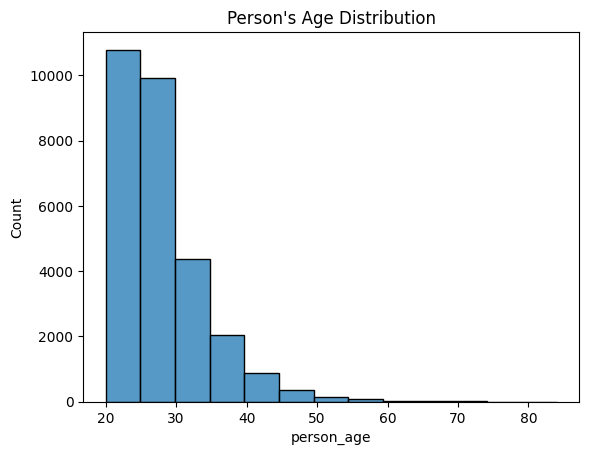

In [22]:
# ckehcing age distribution
sns.histplot(data = df2, x = 'person_age', binwidth = 5)
plt.title("Person's Age Distribution")

The majority of loan applications fall within the 20 to 35 age bracket. This could shed light on the large number of applications being for education.

<Axes: xlabel='person_age', ylabel='loan_amnt'>

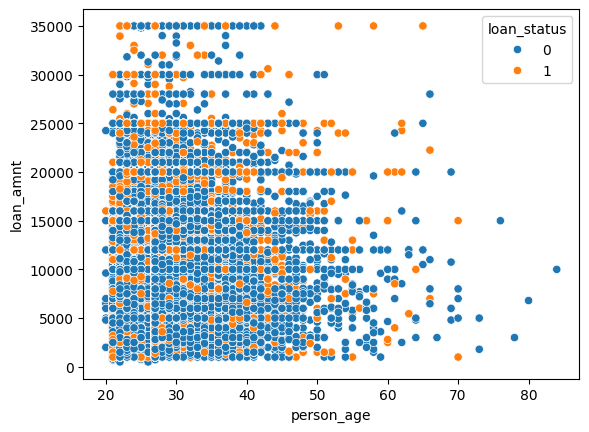

In [23]:
#age vs income
sns.scatterplot(data = df2, x = 'person_age', y = 'loan_amnt', hue = 'loan_status')


There is no significant pattern that explains any kind of relationship between age and the amount according to scatterplot. Similar results were obtained for loan interest plot as well.

<Axes: xlabel='person_age', ylabel='loan_amnt'>

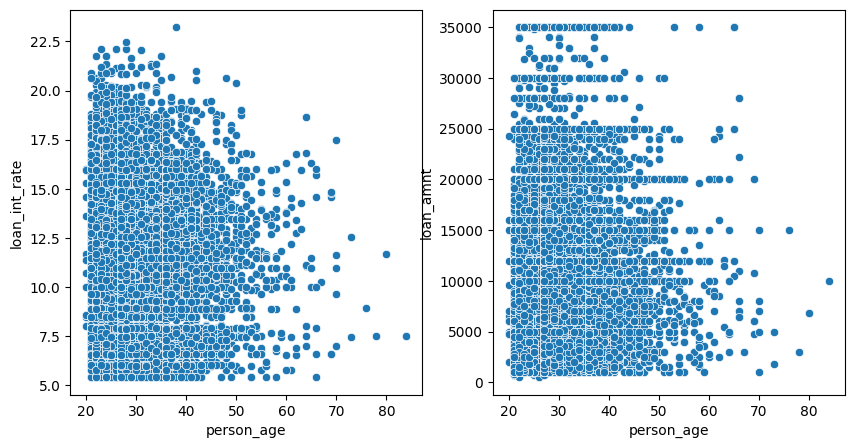

In [24]:
# age vs loan amount and loan rate
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(data = df2, x = 'person_age', y = 'loan_int_rate', ax = ax[0])
sns.scatterplot(data = df2, x = 'person_age', y = 'loan_amnt', ax = ax[1])

In [25]:
# convert yes and no values to 0 and 1
data = df2.copy()
data['cb_person_default_on_file'] = data.cb_person_default_on_file.map(dict(Y = 1, N = 0))

In [26]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4


# Correlation Analysis

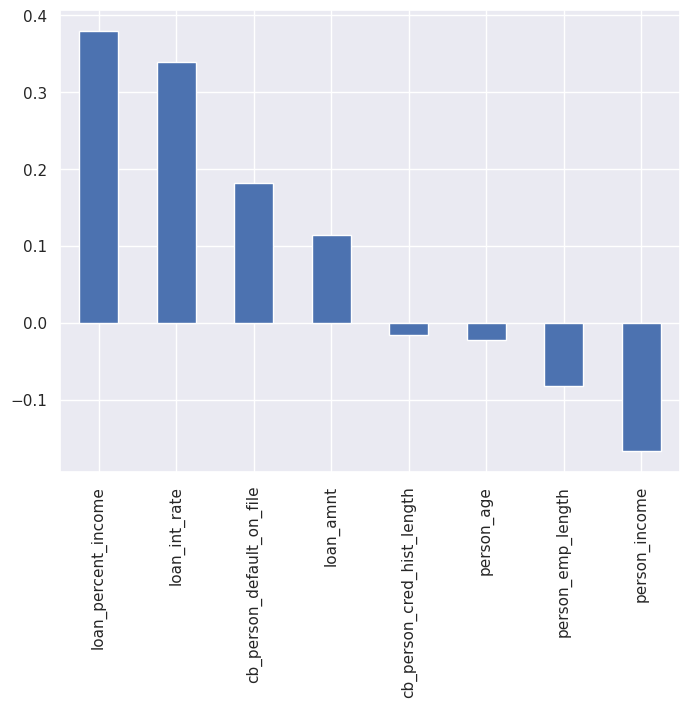

In [34]:
# checking correlation between target and features
conti_df = data.select_dtypes(exclude = [object])

corr_with_tot_count = conti_df.corr()['loan_status'].sort_values(ascending = False)

plt.figure(figsize = (8,6))
corr_with_tot_count.drop('loan_status').plot.bar()
plt.show()

As per the above plot 'loan percent income', 'loan interest rate' are highly
positively correlated with 'person income' being negatively correlated, whereas 'cb person cred history length' has less correlation with targert variable.

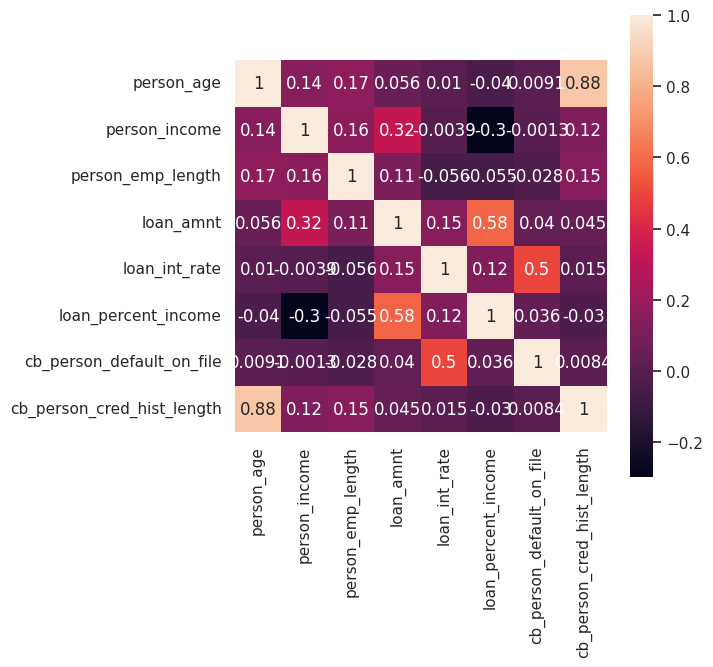

In [35]:
# cheking for correlations among the features
plt.figure(figsize = (6,6))

sns.heatmap(conti_df.drop(['loan_status'], axis = 1).corr(), square = True, annot = True)
plt.show()

Above heatmap indicates a high collinearity between cb person cred history length and person age. Based on this we will drop these two features.

In [36]:
df = data.drop(['cb_person_cred_hist_length', 'person_age'], axis = 1)

## Mututal Information

In [38]:
from sklearn.metrics import mutual_info_score

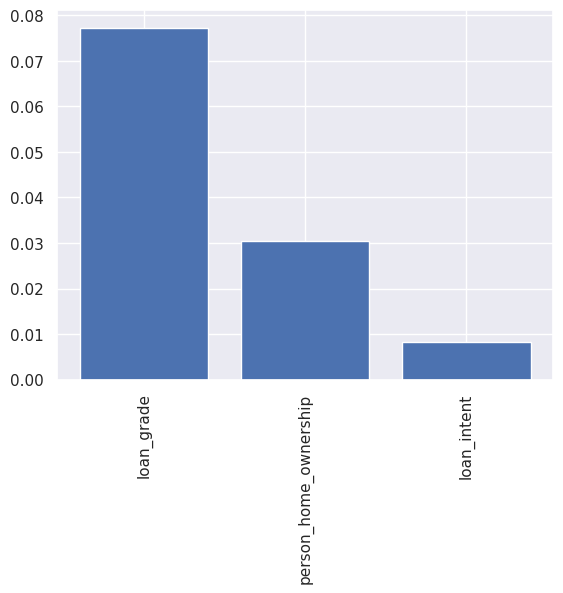

In [40]:
# selectiong important features usinf MI scores
# returns MI score
def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, df.loan_status)

# select categorical variables excluding loan status
cat_var = df.select_dtypes(include = object)

# compute MI score between each categorical variables and target
feature_importance_df = cat_var.apply(compute_mutual_information).sort_values(ascending = False)

# visualize feature importance
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation = 90)
plt.show()

Based on MI scores, loan intent and person home ownership shows very low correlation, so we can drop them.

In [41]:
# select final features
selected_features = df.drop(['loan_intent', 'person_home_ownership'], axis = 1)

In [42]:
# label encoding
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)

In [44]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28634 entries, 0 to 32580
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_income              28634 non-null  int64  
 1   person_emp_length          28634 non-null  float64
 2   loan_grade                 28634 non-null  int64  
 3   loan_amnt                  28634 non-null  int64  
 4   loan_int_rate              28634 non-null  float64
 5   loan_status                28634 non-null  int64  
 6   loan_percent_income        28634 non-null  float64
 7   cb_person_default_on_file  28634 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.0 MB


# Model Training

In [63]:
# returns the model performance in terms of accuracy, classification report and confusion matrix
def model_performance(y_test, y_pred, method):
    #calculate accuracy of model
    print('Accuracy Score:', accuracy_score(y_test, y_pred))

    # generate classification report
    print('classification_report \n')
    print(classification_report(y_test, y_pred))

    # generate confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(conf_mat), annot = True, cmap = 'Blues', fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix:' + method + '\n', y = 1.1)


In [47]:
# selecting features(x) and target(y) variables
x = selected_features.drop(['loan_status'], axis = 1)
y = selected_features['loan_status']

# train test split using stratify sampling to solve the class imbalance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 30)

# Random Forest Classifier
It is a supervised ensemble machine learning algorithm which combines the output of multiple decision trees and can be used for both classification and regression tasks due to its high accuracy and robustness.

In [49]:
rf = RandomForestClassifier(n_estimators=500, oob_score= True, n_jobs = -1, random_state = 50, max_leaf_nodes=30)

rf.fit(x_train, y_train)

pred = rf.predict(x_test)

Accuracy Score: 0.8662475990920202
classification_report 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4486
           1       0.73      0.60      0.66      1241

    accuracy                           0.87      5727
   macro avg       0.81      0.77      0.79      5727
weighted avg       0.86      0.87      0.86      5727



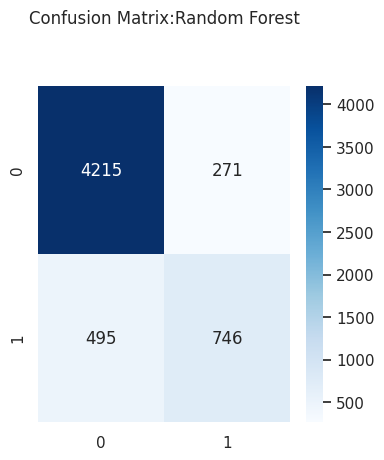

In [64]:
# measurinf model performance
model_performance(y_test, pred, 'Random Forest')

The precision score of 89% and 73% for class 0 and 1 resp, signifies the models ability to accurately identify true positive instances within each class. For class 0, model demonstrates high precision, implying that when it predicts a posotive instance, it is correct 90% of time. However for class 1, precsion of 73% is somewhat less precise.

Recall scores of 94% and 60% for class 0 and 1 resp, indicates the model effectiveness in capturing significant portion of true positive instances for class 0 but less for class 1.

Overall, the model excels in correctly identifying instances of class 0 but there is room for improvement in its performance for class 1.

## Cross validation
Cross-validation is a statistical method used to estimate the performance (or accuracy) of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited.

K-fold cross-validation helps to mitigate the risk of overfitting and provides a more reliable assessment of how well the model is expected to perform on unseen data.


In [65]:
# cross validation
from sklearn.model_selection import RepeatedStratifiedKFold

# apply K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_val_score(rf, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1, error_score = 'raise')

# evaluate performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.875 (0.005)


Accuracy seems pretty consistent with cross validation results.

## Model Tuning
To optimize the performance of our Random Forest classifier, we can use a grid search approach across its various parameters. By systematically exploring different combinations of hyperparameter values, we can find a configuration that improves the model's predictive capabilities. This process allows us to fine-tune the Random Forest classifier and achieve an optimal balance in parameter settings, ultimately improving its overall accuracy and robustness.

In [68]:
# using GridseachCV for random forest to find best parameters
param_grid = {
    'bootstrap': [True],
    'max_depth' : [80,90],
    'n_estimators' : [200,500],
    'max_leaf_nodes' : [20,30]
}

gridsearch = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [69]:
gridsearch.fit(x_train, y_train)
gridsearch.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 200}

In [70]:
gridsearch.best_params_

{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 200}

# XGBoost
XGBoost, which stands for Extreme Gradient Boosting, is a powerful machine learning algorithm often used for both regression and classification tasks. Rooted in the decision tree methodology, XGBoost's strength lies in its ability to sequentially build a multitude of weak learners, iteratively refining the model's predictive accuracy. In the upcoming analysis, we will assess whether integrating an XGBoost model can yield enhancements over the results obtained from the random forest classifier.


In [71]:
# xgboost
# feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [73]:
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [76]:
xgb = XGBClassifier(learning_rate = 0.01,
                    n_estimators = 50,
                    max_depth = 6,
                    random_state = 42,
                    n_jobs = -1)

xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

Accuracy Score: 0.8051335777894185
classification_report 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4486
           1       0.92      0.11      0.20      1241

    accuracy                           0.81      5727
   macro avg       0.86      0.55      0.54      5727
weighted avg       0.83      0.81      0.74      5727



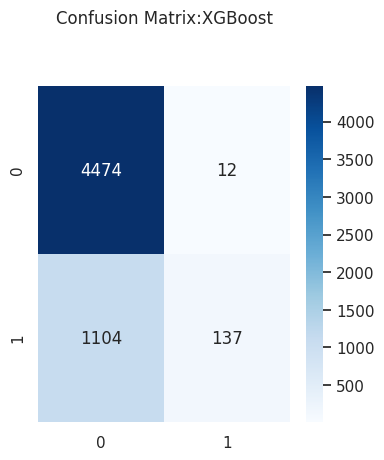

In [77]:
model_performance(y_test, pred, 'XGBoost')

The accuracy score of model is good but when looked at precision, recall, f1 and confusion matrix, this model is not performing well. Is is performing good for class 0 but it is giving more false results for class 1.

Lets do some hyperparameter tuning using grid search cv.

In [79]:
# grid seacrh for XGBClassifier
clf = GridSearchCV(
    xgb,
    {'max_depth': [2,4,6], 'n_estimators' :[50,100,200]},
    verbose = 1,
    n_jobs = 2
)

clf.fit(x_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8742304649487365
{'max_depth': 4, 'n_estimators': 200}


In [88]:
xgb = XGBClassifier(learning_rate = 0.01,
                    n_estimators = 200,
                    max_depth = 4,
                    random_state = 42,
                    n_jobs = -1)

xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

Accuracy Score: 0.8653745416448402
classification_report 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4486
           1       0.75      0.57      0.65      1241

    accuracy                           0.87      5727
   macro avg       0.82      0.76      0.78      5727
weighted avg       0.86      0.87      0.86      5727



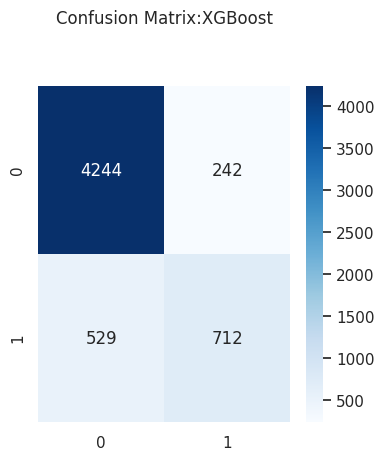

In [89]:
model_performance(y_test, pred, 'XGBoost')

A significant change can be seen after changing some parameters. However when compared with Random Forest Classifier it gives similar overall performance.

# Conclusion
* Comparable Performance: The evaluation of the Random Forest Classifier and XGBoost models reveals similar overall performance in handling the given classification task.
* Limited Experimentation and Hyperparameter Tuning: Acknowledging the constraints of the conducted experiments, it's clear that both models have not undergone an all possible space of hyperparameter settings. Further fine-tuning could potentially enhance their predictive capabilities.